In [2]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

In [3]:
def haldane_hamiltonian(k, params):
    t = params["t"]
    t2 = params["t2"]
    M = params["M"]

    # Define the nearest and next-nearest neighbor vectors for the honeycomb lattice
    delta1 = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
    delta2 = np.array([[0, np.sqrt(3)], [-3/2, -np.sqrt(3)/2], [3/2, -np.sqrt(3)/2]])
    H = np.zeros((2, 2), dtype=complex)

    # Nearest-neighbor hopping term
    for d in delta1:
        H[0, 1] += t * np.exp(1j * np.dot(k, d))
        H[1, 0] += t * np.exp(-1j * np.dot(k, d))

    # On-site potential (staggered potential)
    H[0, 0] += M
    H[1, 1] += -M

    # Next-nearest-neighbor hopping term with complex phase
    for d in delta2:
        H[0, 0] += 2 * t2 * np.sin(np.dot(k,d))
        H[1, 1] += -2 * t2 * np.sin(np.dot(k,d))
    return H


def compute_eigenstuff(H_calculator, kpoints, params):
    """Compute eigenvalues and eigenvectors for a list of k-points"""
    eigvals = []
    eigvecs = []
    for k in kpoints:
        H = H_calculator(k, params)
        val, vec = np.linalg.eigh(H)
        eigvals.append(val)
        eigvecs.append(vec)
    return np.array(eigvals), np.array(eigvecs)

def generate_kgrid(N,a=1):
    """Generate a grid of k-points in the Brillouin zone"""
    kx = np.linspace(-np.pi/a, np.pi/a, N)
    ky = np.linspace(-np.pi/a, np.pi/a, N)
    kpoints = np.array([[kx[i], ky[j]] for i in range(N) for j in range(N)])
    return kpoints


def generate_kpoints_along_path(path, N=100):
    """Generate k-points along a specified path in the Brillouin zone."""
    kpoints = []
    distances = [0]  # This will track the cumulative distance along the path

    # Generate k-points along the path
    for i in range(len(path) - 1):
        start, end = np.array(path[i]), np.array(path[i + 1])
        segment = np.linspace(start, end, N)
        kpoints.extend(segment)

        # Calculate the cumulative distance for each point in the segment
        delta_k = np.linalg.norm(end - start) / N
        for j in range(1, N + 1):
            distances.append(distances[-1] + delta_k)  # Cumulative distance

    kpoints = np.array(kpoints)
    distances = np.array(distances[:len(kpoints)])  # Ensure matching lengths
    return kpoints, distances

def H_calculator(k, params):
    return haldane_hamiltonian(k, params)


### Integration as a summation

In [16]:
def generate_kpoints(kx_min, kx_max, dkx, ky_min, ky_max, dky):
    kx_values = np.arange(kx_min, kx_max + dkx, dkx)
    ky_values = np.arange(ky_min, ky_max + dky, dky)

    kpoints = np.array([[kx, ky] for kx in kx_values for ky in ky_values])

    return kpoints

def compute_berry_curvature_wilson(kpoints, delta, bnd_idx, H_calculator, params):
    _, psi = compute_eigenstuff(H_calculator, kpoints, params)
    _, psi_right = compute_eigenstuff(
        H_calculator, [[kx + delta, ky] for kx, ky in kpoints], params
    )
    _, psi_up = compute_eigenstuff(H_calculator, [[kx, ky + delta] for kx, ky in kpoints], params)
    _, psi_diag = compute_eigenstuff(
        H_calculator, [[kx + delta, ky + delta] for kx, ky in kpoints], params
    )

    # Extract the wavefunction for the specific band
    psi = psi[:, :, bnd_idx]
    psi_right = psi_right[:, :, bnd_idx]
    psi_up = psi_up[:, :, bnd_idx]
    psi_diag = psi_diag[:, :, bnd_idx]

    # Overlaps between wavefunctions at neighboring k-points
    Ox = np.einsum("ij,ij->i", np.conj(psi), psi_right)
    Oy = np.einsum("ij,ij->i", np.conj(psi_right), psi_diag)
    Ox_reverse = np.einsum("ij,ij->i", np.conj(psi_diag), psi_up)
    Oy_reverse = np.einsum("ij,ij->i", np.conj(psi_up), psi)

    # Wilson loop Berry curvature
    berry_curvature = -np.imag(
        np.log(Ox * Oy * Ox_reverse * Oy_reverse)
    )/(delta**2)

    return berry_curvature


def compute_chern_number(kpoints, delta, bnd_idx, H_calculator, params):

    berry_curvature = compute_berry_curvature_wilson(kpoints, delta, bnd_idx, H_calculator, params)
    dkx = kpoints[1,0] - kpoints[0,0]  # Spacing between consecutive kx values
    dky = kpoints[1,1] - kpoints[0,1]  # Spacing between consecutive ky values
    chern_number = np.sum(berry_curvature* dkx * dky) / (2 * np.pi)
    return chern_number


### Integration using built in scipy library

In [5]:
import numpy as np
from scipy.integrate import nquad

def compute_berry_curvature(kx, ky, H_calculator, bnd_idx, params,degenerate, delta=1e-2):
    # sourcery skip: inline-immediately-returned-variable
    """Compute the Berry curvature at a given k-point (kx, ky) using finite differences."""
    kpoints = np.array([[kx, ky], [kx + delta, ky], [kx, ky + delta], [kx + delta, ky + delta]])

    # Compute the eigenvalues and eigenvectors at the relevant k-points
    _, psi = compute_eigenstuff(H_calculator, [kpoints[0]], params)
    _, psi_right = compute_eigenstuff(H_calculator, [kpoints[1]], params)
    _, psi_up = compute_eigenstuff(H_calculator, [kpoints[2]], params)
    _, psi_diag = compute_eigenstuff(H_calculator, [kpoints[3]], params)

    # Extract the wavefunction for the specific band
    psi = psi[:, :, bnd_idx]
    psi_right = psi_right[:, :, bnd_idx]
    psi_up = psi_up[:, :, bnd_idx]
    psi_diag = psi_diag[:, :, bnd_idx]

    # Overlaps between wavefunctions at neighboring k-points
    if degenerate:
        Ox = np.linalg.det(np.dot(psi[0].conj().T, psi_right[0]))
        Oy = np.linalg.det(np.dot(psi_right[0].conj().T, psi_diag[0]))
        Ox_reverse = np.linalg.det(np.dot(psi_diag[0].conj().T, psi_up[0]))
        Oy_reverse = np.linalg.det(np.dot(psi_up[0].conj().T, psi[0]))

    else:
        Ox = np.vdot(psi, psi_right)
        Oy = np.vdot(psi_right, psi_diag)
        Ox_reverse = np.vdot(psi_diag, psi_up)
        Oy_reverse = np.vdot(psi_up, psi)

    # Wilson loop Berry curvature
    berry_phase = np.imag(np.log(Ox * Oy * Ox_reverse * Oy_reverse))
    berry_curvature = -berry_phase / (delta**2)
    return berry_curvature


def integrate_berry_curvature(H_calculator, bnd_idx, params, a=1.0,degenerate=False):
    """Integrate the Berry curvature over the entire Brillouin zone using scipy.nquad."""
    def integrand(kx, ky):
        # return berry_curvature(kx, ky, H_calculator, bnd_idx, params)
        return compute_berry_curvature(kx, ky, H_calculator, bnd_idx, params,degenerate)

    # Limits for kx and ky integration over the Brillouin zone
    kx_limits = (-np.pi/a, np.pi/a)
    ky_limits = (-2*np.pi/(np.sqrt(3)*a), 2*np.pi/(np.sqrt(3)*a))

    # Perform the numerical integration using nquad
    result, _ = nquad(integrand, [kx_limits, ky_limits])
    # Chern number is the integral of Berry curvature divided by 2π
    chern_number = result / (2 * np.pi)
    return chern_number


In [6]:
params = {
    "t": 1.0,
    "t2": 0.05,
    "M": 0.2
}
chern_number = integrate_berry_curvature(H_calculator, bnd_idx=[0], params=params,degenerate=True)
print("Chern number:", chern_number)

Chern number: 3.000000000000136


In [17]:
params = {
    "t": 1.0,
    "t2": 0.05,
    "M": 0.2
}
chern_number = integrate_berry_curvature(H_calculator, bnd_idx=0, params=params,degenerate=False)
print("Chern number:", chern_number)

KeyboardInterrupt: 

In [18]:
a = 1
kx_min,kx_max,dkx = -np.pi/a, np.pi/a, 0.1
ky_min,ky_max,dky = -2*np.pi/(np.sqrt(3)*a), 2*np.pi/(np.sqrt(3)*a),0.1
kpoints = generate_kpoints(kx_min, kx_max, dkx, ky_min, ky_max, dky)

chern_number = compute_chern_number(kpoints, delta=1e-2, bnd_idx=0, H_calculator=H_calculator, params=params)
print("Chern number:", chern_number)

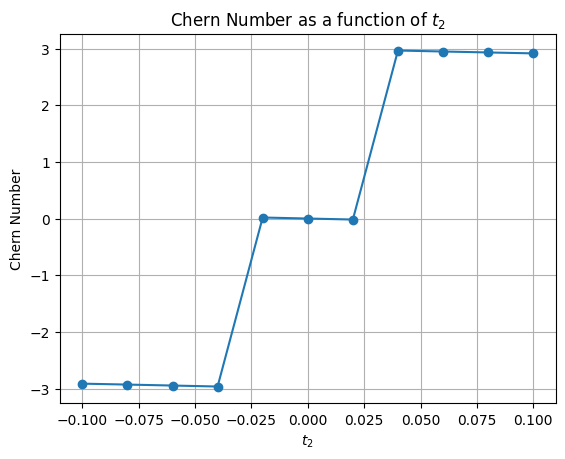

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of t2 values
t2_values = np.arange(-0.1, 0.11, 0.02)  # t2 values from -0.1 to 0.1 in steps of 0.05
chern_numbers = []

# Loop over t2 values and compute the corresponding Chern number
for t2 in t2_values:
    params = {
    "t": 1.0,  # fixed value
    "t2": t2,  # varying t2
    "M": 0.2  # fixed value
    }
    chern_number = integrate_berry_curvature(H_calculator, bnd_idx=0, params=params)
    chern_numbers.append(chern_number)

# Plot the Chern number as a function of t2
plt.plot(t2_values, chern_numbers, marker='o')
plt.xlabel('$t_2$')
plt.ylabel('Chern Number')
plt.title('Chern Number as a function of $t_2$')
plt.grid(True)
plt.show()


### Parallelization over kpoints

In [ ]:
from mpi4py import MPI
import numpy as np

def parallel_compute_chern_number(kpoints, delta, bnd_idx, H_calculator, params):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Split kpoints among processes
    num_kpoints = len(kpoints)
    kpoints_per_proc = num_kpoints // size
    if rank < num_kpoints % size:
        start = rank * (kpoints_per_proc + 1)
        end = start + kpoints_per_proc + 1
    else:
        start = rank * kpoints_per_proc + num_kpoints % size
        end = start + kpoints_per_proc

    local_kpoints = kpoints[start:end]

    # Each process computes Berry curvature for its local kpoints
    local_berry_curvature = compute_berry_curvature_wilson(local_kpoints, delta, bnd_idx, H_calculator, params)

    # Gather results from all processes
    berry_curvature = None
    if rank == 0:
        berry_curvature = np.empty(num_kpoints, dtype=np.float64)
    comm.Gather(local_berry_curvature, berry_curvature, root=0)

    # Compute the Chern number on the root process
    if rank == 0:
        dkx = kpoints[1,0] - kpoints[0,0]  # Spacing between consecutive kx values
        dky = kpoints[1,1] - kpoints[0,1]  # Spacing between consecutive ky values
        chern_number = np.sum(berry_curvature * dkx * dky) / (2 * np.pi)
        return chern_number
    else:
        return None

# MPI initialization
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# Generate kpoints (only on rank 0)
if rank == 0:
    a = 1
    kx_min, kx_max, dkx = -np.pi/a, np.pi/a, 0.1
    ky_min, ky_max, dky = -2*np.pi/(np.sqrt(3)*a), 2*np.pi/(np.sqrt(3)*a), 0.1
    kpoints = generate_kpoints(kx_min, kx_max, dkx, ky_min, ky_max, dky)
else:
    kpoints = None

# Broadcast kpoints to all processes
kpoints = comm.bcast(kpoints, root=0)

# Compute Chern number in parallel
chern_number = parallel_compute_chern_number(kpoints, delta=1e-2, bnd_idx=0, H_calculator=H_calculator, params=params)

# Print result on rank 0
if rank == 0:
    print("Chern number:", chern_number)
